# Share Price Predictor
### This solution predicts the next day share value using deep learning with RNN. The model is trained using the past one year share details using Yahoo API through Pandas DataReader library

In [1]:
# Common imports
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import time

#For Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#For getting the share details from Stock Market/Brokerage API
from pandas_datareader import data
from datetime import datetime

#For Deep Learning
import tensorflow as tf

#### Download the past stock price data for 1 year using the Yahoo Data Reader

In [2]:
#Declare a data dictionary contaning with the shares of interest as key and display name as value
share_dict = {'WMT':'Walmart Inc', 'AMZN':'Amazon', 'DE':'John Deere', 'GOOG': 'Google'}

In [3]:
start_time = time.time()

end_period = datetime.now()
start_period = datetime(end_period.year-1, end_period.month, end_period.day)
stocksData = []
share_details_dict = {}

for key, value in share_dict.items():
    stockData = data.DataReader(key, 'yahoo', start_period , end_period)
    stocksData.append(stockData)
    share_details_dict[key] = stockData
    
for key, value in share_dict.items():
     globals() [key] = data.DataReader(key, 'yahoo', start_period , end_period)
        
end_time = time.time()
print('Elapsed Time: {}'.format(np.round(((end_time - start_time)/60),2)))
    

Elapsed Time: 0.12


#### print dataframe meta data

In [4]:
for key, value in share_dict.items():
    name = share_dict[key]
    print(name)
    print('-----------')
    val = share_details_dict[key]
    print (val.describe())
    print('************')

Walmart Inc
-----------
             High         Low        Open       Close        Volume  \
count  250.000000  250.000000  250.000000  250.000000  2.500000e+02   
mean    95.673960   94.225320   94.887560   94.962080  7.868656e+06   
std      5.628721    5.539734    5.624526    5.587032  3.600193e+06   
min     82.519997   81.809998   81.959999   82.400002  3.727800e+06   
25%     92.147501   90.257500   91.237501   91.207500  5.678200e+06   
50%     96.655003   95.225002   95.864998   95.880001  7.104000e+06   
75%     99.457500   98.027498   98.567501   98.705000  9.032425e+06   
max    106.209999  104.809998  105.500000  105.559998  4.263130e+07   

        Adj Close  
count  250.000000  
mean    93.725158  
std      5.931513  
min     80.615227  
25%     90.239994  
50%     94.539955  
75%     97.790514  
max    103.873398  
************
Amazon
-----------
              High          Low         Open        Close        Volume  \
count   250.000000   250.000000   250.000000   25

In [5]:
for key, value in share_dict.items():
    name = share_dict[key]
    print(name)
    print('-----------')
    val = share_details_dict[key]
    print(val.info())
    print('************')

Walmart Inc
-----------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-05-29 to 2019-05-24
Data columns (total 6 columns):
High         250 non-null float64
Low          250 non-null float64
Open         250 non-null float64
Close        250 non-null float64
Volume       250 non-null float64
Adj Close    250 non-null float64
dtypes: float64(6)
memory usage: 13.7 KB
None
************
Amazon
-----------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-05-29 to 2019-05-24
Data columns (total 6 columns):
High         250 non-null float64
Low          250 non-null float64
Open         250 non-null float64
Close        250 non-null float64
Volume       250 non-null int64
Adj Close    250 non-null float64
dtypes: float64(5), int64(1)
memory usage: 13.7 KB
None
************
John Deere
-----------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-05-29 to 2019-05-24
Data columns (total 6 columns):
High         250 non-null float

#### Visualize the stock data

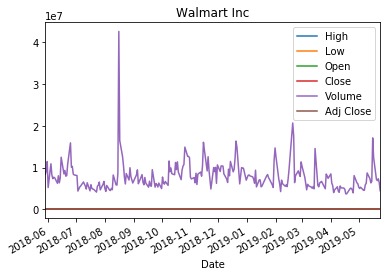

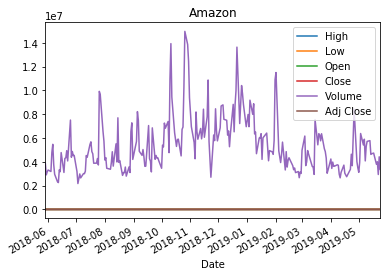

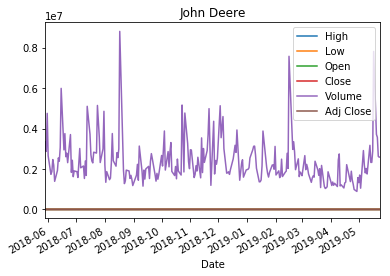

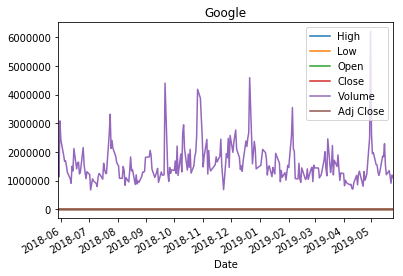

In [6]:
for key, value in share_dict.items():
    name = share_dict[key]
    share_details_dict[key].plot().set_title(name)


In [7]:
share_to_predict = 'WMT'

In [8]:
# divide the data into small batches and use them to train
def next_batch(share, batch_size, num_steps):
    x_batch = np.zeros((batch_size,num_steps))
    y_batch = np.zeros((batch_size,num_steps))
    
    for i in range(batch_size):
        stindex = np.random.randint(0,250-num_steps-1)
        #print(stindex)
        endindex = stindex + num_steps
        x_batch[i] = share_details_dict[share].iloc[:,0].values[stindex: stindex + num_steps]
        y_batch[i] = share_details_dict[share].iloc[:,0].values[stindex+1: stindex+num_steps+1]
    return x_batch, y_batch


In [9]:
x_batch, y_batch  = next_batch(share_to_predict,10,20)

In [10]:
x_batch.shape, y_batch.shape

((10, 20), (10, 20))

In [11]:
x_batch[1]

array([103.80000305, 103.54000092, 103.29000092, 103.84999847,
       104.15000153, 102.33999634, 102.        , 102.91999817,
       102.80999756, 102.05999756, 102.75      , 102.55000305,
       102.16999817, 101.04000092,  99.94000244, 102.11000061,
       101.15000153, 100.87000275, 100.36000061, 103.95999908])

In [12]:
y_batch[1]

array([103.54000092, 103.29000092, 103.84999847, 104.15000153,
       102.33999634, 102.        , 102.91999817, 102.80999756,
       102.05999756, 102.75      , 102.55000305, 102.16999817,
       101.04000092,  99.94000244, 102.11000061, 101.15000153,
       100.87000275, 100.36000061, 103.95999908, 101.94999695])

In [13]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

#### Deep Learning using Tensorflow
Find the share price 1 day ahead

In [14]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [15]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [16]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [17]:
learning_rate = 0.001
# MSE
loss = tf.reduce_mean(tf.square(outputs - y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [18]:
# save the trained model so that it can be used later
saver = tf.train.Saver()
n_iterations = 1000
batch_size = 15

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(share_to_predict,batch_size, n_steps)
        X_batch = X_batch.reshape(batch_size,n_steps,1)
        y_batch = y_batch.reshape(batch_size,n_steps,1)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./share_predictor_model") # not shown in the content

0 	MSE: 5965.366
100 	MSE: 114.49625
200 	MSE: 17.802738
300 	MSE: 1.8653873
400 	MSE: 1.290018
500 	MSE: 1.3042163
600 	MSE: 1.8338599
700 	MSE: 1.7304573
800 	MSE: 1.1955584
900 	MSE: 2.0700643


In [19]:
# restore the saved model
# pass the input to the model and get the prediction
with tf.Session() as sess:
    saver.restore(sess, "./share_predictor_model")

    X_new = share_details_dict[share_to_predict].iloc[:,0].values[109:129]
    X_new = X_new.reshape(1,20,1)
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    y_true= share_details_dict[share_to_predict].iloc[:,0].values[110:130]
    print(y_pred)

INFO:tensorflow:Restoring parameters from ./share_predictor_model
[[[102.528435]
  [101.28192 ]
  [101.57422 ]
  [102.79469 ]
  [103.24103 ]
  [104.16463 ]
  [105.02354 ]
  [105.58295 ]
  [106.07841 ]
  [104.07647 ]
  [103.04986 ]
  [102.64998 ]
  [ 99.59574 ]
  [ 98.057434]
  [ 95.39779 ]
  [ 95.016266]
  [ 95.70989 ]
  [ 96.137375]
  [ 95.5473  ]
  [ 97.46243 ]]]


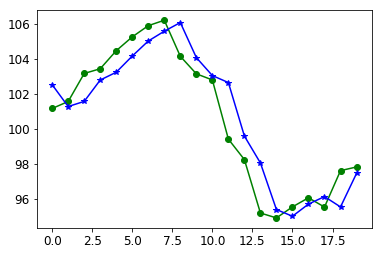

In [20]:
plt.plot(y_true, marker="o", color="green")
plt.plot(y_pred.ravel(), marker="*", color="blue")

In [21]:
#View First 5 records
share_details_dict[share_to_predict]['Adj Close'].head()

Date
2018-05-29    80.615227
2018-05-30    82.297974
2018-05-31    80.752197
2018-06-01    81.192436
2018-06-04    83.569817
Name: Adj Close, dtype: float64

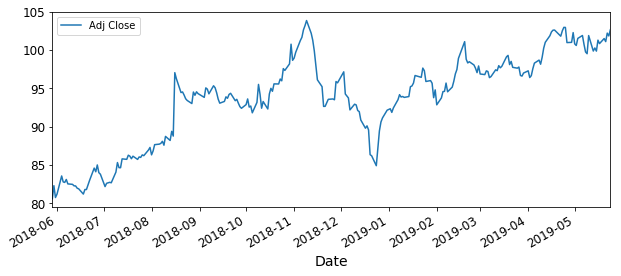

In [22]:
share_details_dict[share_to_predict]['Adj Close'].plot(legend=True, figsize=(10,4))

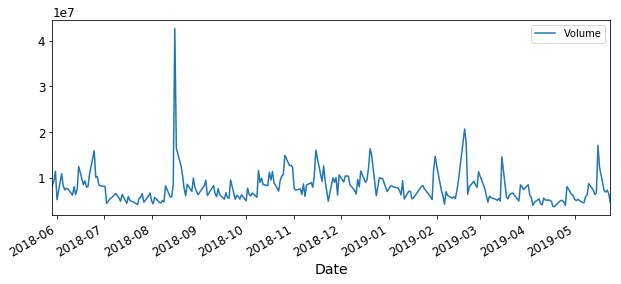

In [23]:
#view volume of stock traded every day
share_details_dict[share_to_predict]['Volume'].plot(legend=True, figsize=(10,4))

#### plot all stock performances  on Adj close for entire year

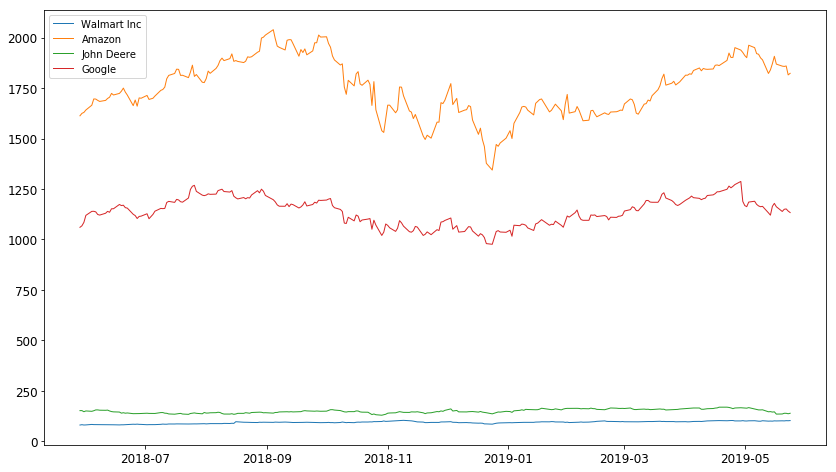

In [24]:
plt.figure(figsize=(14,8))

for key, value in share_dict.items():
    name = share_dict[key]
    plt.plot(share_details_dict[key]['Adj Close'], label=name, linewidth=1)
    
plt.legend()
plt.show()

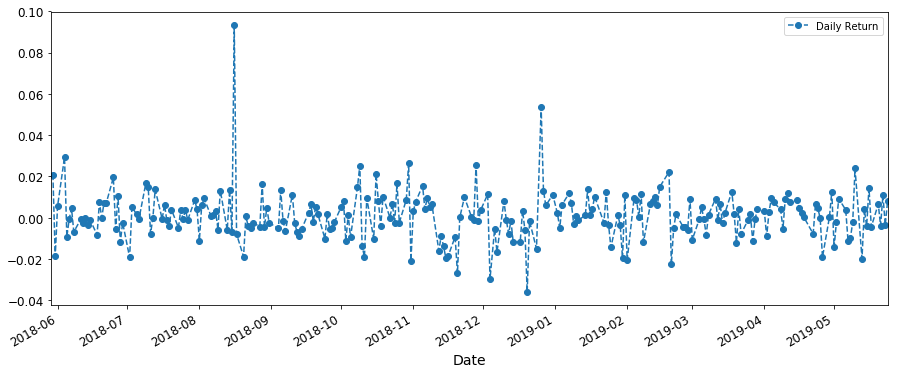

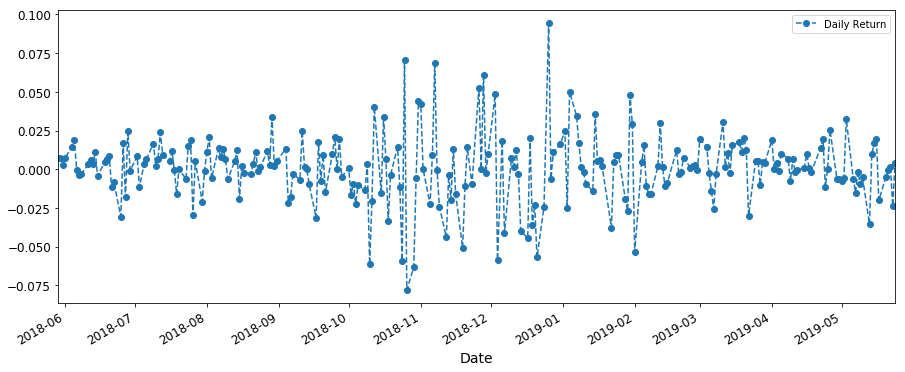

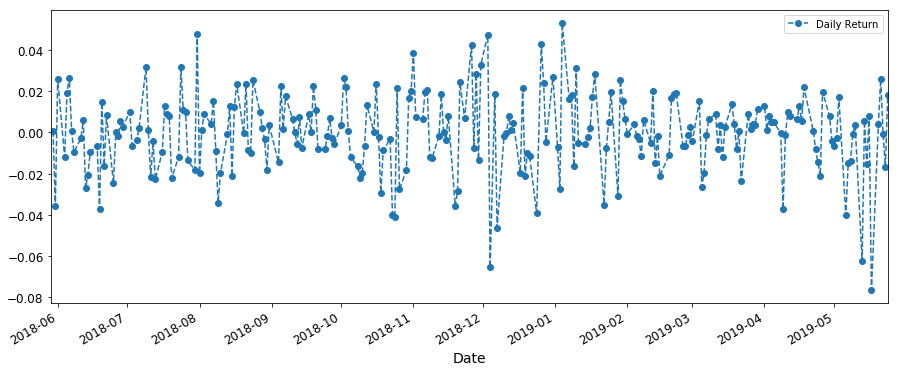

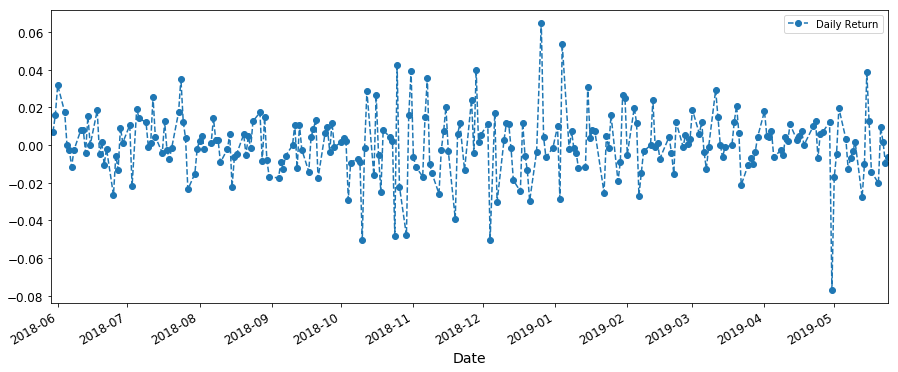

In [25]:
for key, value in share_dict.items():
    name = share_dict[key]
    share_details_dict[key]['Daily Return'] = share_details_dict[key]['Adj Close'].pct_change()
    share_details_dict[key]['Daily Return'].plot(figsize=(15,6), legend=True, linestyle='--', marker='o')
    plt.show()
    

In [26]:
#Fetch closing prices
closing_price_stock = data.DataReader(list(share_dict.keys()), 'yahoo', start_period, end_period)['Adj Close']

In [27]:
closing_price_stock.head()

Symbols,AMZN,DE,GOOG,WMT
Date,,,,
2018-05-29,1612.869995,152.015060,1060.319946,80.615227
2018-05-30,1624.890015,152.083725,1067.800049,82.297974
2018-05-31,1629.619995,146.621323,1084.989990,80.752197
2018-06-01,1641.540039,150.426361,1119.500000,81.192436
2018-06-04,1665.270020,148.612122,1139.290039,83.569817


In [28]:
stock_returns = closing_price_stock.pct_change()

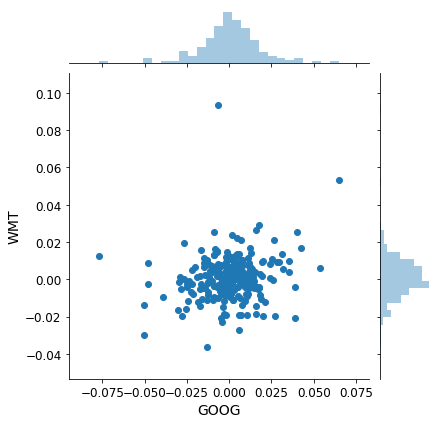

In [29]:
#compare daily returns of Google and Walmart
sns.jointplot('GOOG', 'WMT', stock_returns,kind='scatter')

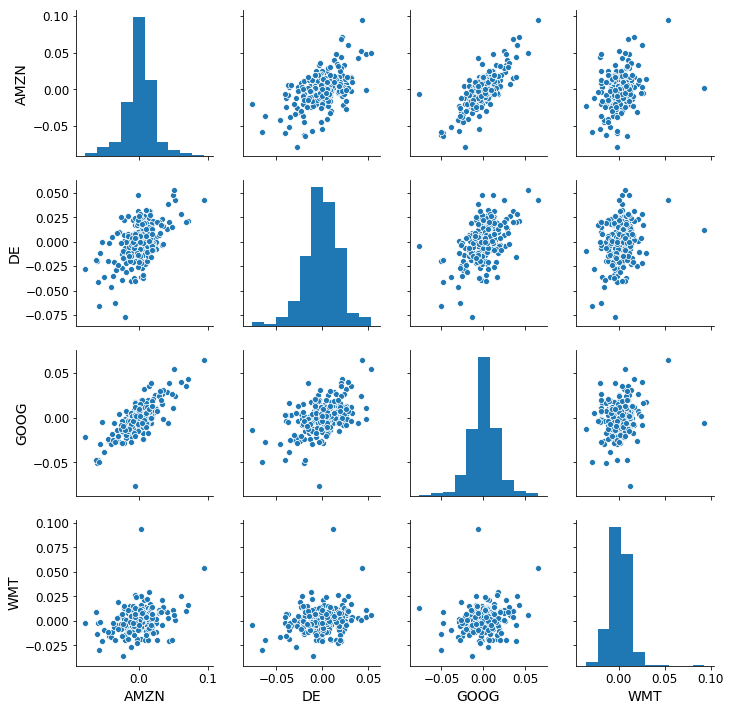

In [30]:
sns.pairplot(stock_returns.dropna())